In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, multivariate_normal

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

In [2]:
#plt.rcParams["figure.figsize"] = (10, 4)
#plt.rcParams['figure.dpi'] = 200

## Global parameters

In [3]:
# Mock parameters
cosmology=fiducial.AbacusSummitBase()
z = 1.175
bias = 1.8

# Mocks
nmocks = 5000

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

In [4]:
# DS correlation functions parameters
ells = [0]
nells = len(ells)
randoms_size = 4
nsplits = 3

## Abacus mock to compare to model

In [5]:
data_dir = '/feynman/work/dphp/mp270220/'
catalog_name = 'data/AbacusSummit_2Gpc_z1.175'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
nbar = catalog.size/catalog.boxsize**3

ccf_name = 'outputs/correlation_functions/AbacusSummit_2Gpc_z1.175_densitySplit_rh_CCFs_cellsize10_randomsize4.npy'

In [6]:
nbar

0.00293291175

In [7]:
nbar = sum(catalog.weights)/catalog.boxsize**3

In [8]:
catalog_density = density_split.DensitySplit(catalog)
catalog_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

[000005.78]  03-10 15:01  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 23463294.
[000006.80]  03-10 15:01  CatalogMesh                  INFO     Painted 4194304 out of 23463294 objects to mesh.
[000006.80]  03-10 15:01  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 23463294.
[000007.82]  03-10 15:01  CatalogMesh                  INFO     Painted 8388608 out of 23463294 objects to mesh.
[000007.82]  03-10 15:01  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 23463294.
[000008.88]  03-10 15:01  CatalogMesh                  INFO     Painted 12582912 out of 23463294 objects to mesh.
[000008.88]  03-10 15:01  CatalogMesh                  INFO     Slab 12582912 ~ 16777216 / 23463294.
[000010.12]  03-10 15:01  CatalogMesh                  INFO     Painted 16777216 out of 23463294 objects to mesh.
[000010.12]  03-10 15:01  CatalogMesh                  INFO     Slab 16777216 ~ 20971520 / 23463294.
[000011.33]  03-10 15:01  CatalogMesh               

In [9]:
catalog_density.split_density(3)

In [10]:
catalog_density.split_bins

array([-0.975165  ,  0.09070959,  0.90650268, 24.90036862])

In [11]:
catalog_density.split_densities[0].max()

0.09070945042196463

In [12]:
densities = catalog_density.data_densities

In [13]:
sigma_RR = np.std(densities)
sigma_RR

1.1662688627496927

## Compute $\xi_R$

In [14]:
def compute_xi_R(data_density, edges, seed=0, los=None, use_rsd=False, use_weights=False, nthreads=128):
    data = data_density.data

    if use_rsd and data.positions_rsd is not None:
        positions2 = data.positions_rsd
    else:
        positions2 = data.positions

    if use_weights and (data.weights is not None):
        weights2 = data.weights
    else:
        weights2 = None

    ## Generate random particles and readout density at each particle
    rng = np.random.RandomState(seed=seed)
    positions1 = [o + rng.uniform(0., 1., data_density.data.size)*b for o, b in zip((data_density.offset,)*3, (data_density.boxsize,)*3)]
    shifted_positions1 = np.array(positions1) - data_density.offset
    densities = data_density.density_mesh.readout(shifted_positions1.T, resampler=data_density.resampler)

    weights1 = 1 + densities

    result = TwoPointCorrelationFunction('smu', edges,
                                        data_positions1=positions1, data_positions2=positions2,
                                        data_weights1=weights1, data_weights2=weights2,
                                        boxsize=data_density.boxsize,
                                        engine='corrfunc', nthreads=nthreads,
                                        los = los)

    return result

In [15]:
abacus_xi_R = compute_xi_R(catalog_density, edges=(np.linspace(0., 150., 151), np.linspace(-1, 1, 201)), seed=0, los='x', use_rsd=False, use_weights=True, nthreads=128)

[000023.84]  03-10 15:01  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000023.84]  03-10 15:01  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000626.16]  03-10 15:11  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.


In [16]:
abacus_xi_R

In [17]:
test = abacus_xi_R.get_corr(ells=ells, return_sep=False) 
test.shape

(1, 150)

## Initialize Gaussian model

In [18]:
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=bias, nbar=nbar)

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/code/cosmoprimo/main/lib/python3.9/site-packages/cosmoprimo/interpolator.py:517: ComplexWarning: Casting complex values to real discards the imaginary part
  k = np.asarray(k, dtype=dtype)


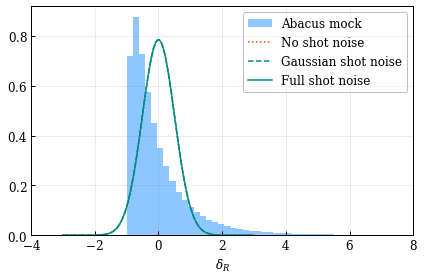

In [19]:
delta = np.linspace(-3, 3, 100)

model_density_no_shot_noise = scipy.stats.norm.pdf(delta, 0, model.sigma_RR)
model_density_gaussian_shot_noise = model.density_with_shot_noise(delta, p=2)
model_density_full_shot_noise = model.density_with_shot_noise(delta, p=4)

plt.hist(np.ravel(catalog_density.density_mesh), bins=200, density=True, alpha=0.5, label='Abacus mock')
plt.plot(delta, model_density_no_shot_noise, label='No shot noise', ls=':', color='orangered')
plt.plot(delta, model_density_gaussian_shot_noise, label='Gaussian shot noise', ls='--', color='darkcyan')
plt.plot(delta, model_density_full_shot_noise, label='Full shot noise', ls='-', color='darkcyan')
plt.xlabel(r'$\delta_R$')
plt.xlim((-4, 8))

plt.legend()
plt.savefig('gaussianModelvsAbacusMock_weights_delta_R.pdf', dpi=200)
#plt.savefig('gaussianModelvsAbacusMock_delta_R.pdf', dpi=200)
plt.show()

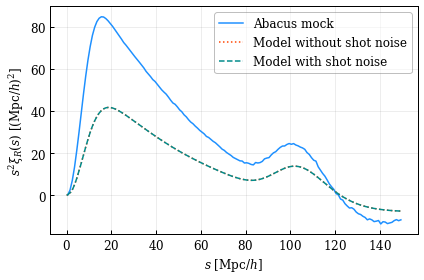

In [20]:
s, xi_R_mock = abacus_xi_R.get_corr(ells=ells, return_sep=True) 

plt.plot(s, s**2 * xi_R_mock[0], label='Abacus mock')
plt.plot(model.sep, model.sep**2 * model.xi_R, label=r'Model without shot noise', ls=':')
plt.plot(model.sep, model.sep**2 * model.xi_R_with_shot_noise, label=r'Model with shot noise', ls='--')

plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.savefig('gaussianModelvsAbacusMock_weights_xi_R.pdf', dpi=200)
#plt.savefig('gaussianModelvsAbacusMock_xi_R.pdf', dpi=200)
plt.show()

In [17]:
abacus_ccf_rh = np.load(data_dir+ccf_name, allow_pickle=True)
abacus_xiell_rh = [res.get_corr(ells=ells, return_sep=False) for res in abacus_ccf_rh]

In [18]:
s, _, res = abacus_ccf_rh[0].get_corr(return_sep=True)

In [19]:
from pandas import qcut
test, th_bins = qcut(densities, nsplits, retbins=True)

In [20]:
th_bins

array([-0.93349609,  0.20459776,  0.770185  ,  5.2546852 ])

In [21]:
#th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)

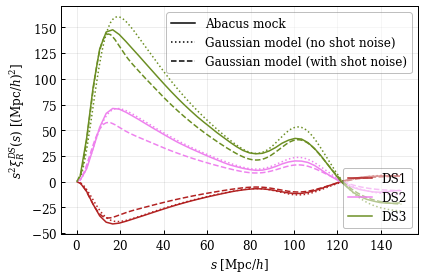

In [43]:
## Model
ccf_RH = model.ccf_randoms_tracers(density_bins=th_bins, shot_noise=False)
ccf_RH_shot_noise = model.ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=4)

colors = ['firebrick', 'violet', 'olivedrab']

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        y = s**2 * abacus_xiell_rh[ds][ill]

        plt.plot(s, y, color=colors[ds])
        plt.plot(model.sep, model.sep**2 * ccf_RH[ds], ls=':', color=colors[ds])
        plt.plot(model.sep, model.sep**2 * ccf_RH_shot_noise[ds], ls='--', color=colors[ds])
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

lines = list()
for ds in range(nsplits):
    line, = plt.plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
    lines.append(line)
line2, = plt.plot([], [], ls='-', color='black', label='Abacus mock')
line3, = plt.plot([], [], ls=':', color='black', label='Gaussian model (no shot noise)')
line4, = plt.plot([], [], ls='--', color='black', label='Gaussian model (with shot noise)')

first_legend = plt.legend(handles=lines, loc='lower right')
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[line2, line3, line4], loc='upper right')

plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.savefig('gaussianModelvsAbacusMock_densitysplits_rh.pdf', dpi=200)
plt.show()

-0.11544096078462279
0.4761781149728762
1.3137208263600095


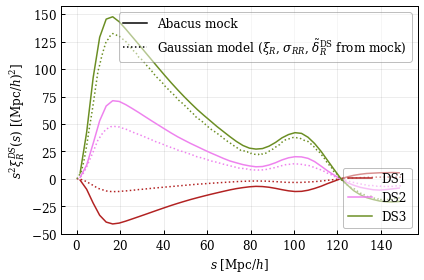

In [52]:
colors = ['firebrick', 'violet', 'olivedrab']

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        # Mock
        y = s**2 * abacus_xiell_rh[ds][ill]
        
        # Adapt model to mock
        d1 = th_bins[ds]
        d2 = th_bins[ds+1]
        
        split = np.logical_and((densities > d1), (densities <= d2))
        split_densities = densities[split]
        delta_tilde = np.mean(split_densities)
        print(delta_tilde)
        split_model = abacus_xi_R.get_corr(ells=ells, return_sep=False).T * delta_tilde / sigma_RR**2

        plt.plot(s, y, color=colors[ds])
        plt.plot(model.sep, model.sep**2 * split_model, ls=':', color=colors[ds])
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

lines = list()
for ds in range(nsplits):
    line, = plt.plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
    lines.append(line)
line2, = plt.plot([], [], ls='-', color='black', label=r'Abacus mock')
line3, = plt.plot([], [], ls=':', color='black', label=r'Gaussian model ($\xi_R$, $\sigma_{RR}$, $\tilde{\delta}_{R}^{\mathrm{DS}}$ from mock)')

first_legend = plt.legend(handles=lines, loc='lower right')
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[line2, line3], loc='upper right')

plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
#plt.savefig('gaussianModelAdaptedvsAbacusMock_densitysplits_rh.pdf', dpi=200)
plt.show()

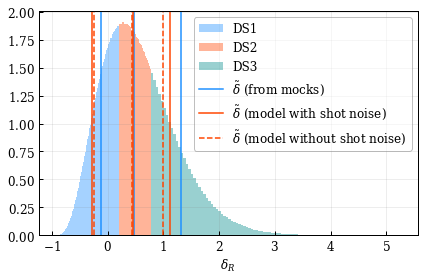

In [61]:
delta = np.linspace(-3, 3, 100)

model_density_no_shot_noise = scipy.stats.norm.pdf(delta, 0, model.sigma_RR)
model_density_gaussian_shot_noise = model.density_with_shot_noise(delta, p=2)
model_density_full_shot_noise = model.density_with_shot_noise(delta, p=4)

for i in range(catalog_density.nsplits):
    plt.hist(catalog_density.split_densities[i], bins=100, density=True, alpha=0.4, label='DS{}'.format(i+1))
#plt.plot(delta, model_density_no_shot_noise, label='No shot noise', ls=':', color='orangered')
#plt.plot(delta, model_density_gaussian_shot_noise, label='Gaussian shot noise', ls='--', color='darkcyan')
#plt.plot(delta, model_density_full_shot_noise, label='Full shot noise', ls='-', color='darkcyan')
plt.xlabel(r'$\delta_R$')

plt.axvline(-0.11544096078462279, label=r'$\tilde{\delta}$ (from mocks)')
plt.axvline(0.4761781149728762)
plt.axvline(1.3137208263600095)
plt.axvline(model.delta_tilde[0], color='orangered', ls='-', label=r'$\tilde{\delta}$ (model with shot noise)')
plt.axvline(model.delta_tilde[1], color='orangered', ls='-')
plt.axvline(model.delta_tilde[2], color='orangered', ls='-')
dtilde = model.compute_delta_tilde(th_bins, shot_noise=False)
plt.axvline(dtilde[0], color='orangered', ls='--', label=r'$\tilde{\delta}$ (model without shot noise)')
plt.axvline(dtilde[1], color='orangered', ls='--')
plt.axvline(dtilde[2], color='orangered', ls='--')
   
plt.legend()
plt.show()

In [62]:
model.sigma_RR

array([0.50788184])

In [33]:
sigma_RR

0.6655606457713437

In [63]:
np.sqrt(model.density_moments[1]-1)

array([0.61735852])